# Objective:

How can predictive modeling do with predicting players that will get a hit in a baseball game? First, in order to predict a hit, what variables can a model be trained on?

# Outline:

- STEP 1: Load and prepare the data
- STEP 2: Explore and visualize

In [2]:
# Imports
import pandas as pd
import seaborn as sns # plotting
from statsmodels.graphics.gofplots import qqplot
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc

In [39]:
# Function to visualize confusion matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

# Step 1: Load and Prepare

What data can be downloaded each day to predict a hit? Baseball Savant's batted ball data from 2018 will give me 40,000 individual events. Let's explore and visualize what we have.

In [3]:
# Load data
df = pd.read_csv('savant_dataTRAIN.csv')

In [4]:
# How much do we have?
df.shape

(40000, 89)

In [5]:
# What are the features?
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [6]:
# How many features do we have?
len(df.columns)

89

#### NOTE: 

We have a ton of data here for one individual at batted-ball event. An issue will be first, deciding what features are actually predictive of a hit and can train the model. However, those predictive features need to be able to be accessed in order to predict. For example, if I want to find out whether or not player A will get a hit before a game, I need to be able to run known values through the model. Therefore, I cannot use features that have not yet occured, like how hard the ball was hit, because they haven't happened yet.

# STEP 1a: Designate a target

I'm trying to predict an outcome of a hit. Therefore, my model needs to have a categorical target, 0=non-hit and 1=hit.

In [7]:
# Categorize the events 
df['events'].unique()

array(['single', 'field_out', 'home_run', 'force_out', 'double',
       'grounded_into_double_play', 'double_play', 'sac_fly', 'triple',
       'fielders_choice_out', 'sac_bunt', 'fielders_choice',
       'sac_fly_double_play', 'sac_bunt_double_play', 'triple_play'],
      dtype=object)

In [8]:
# Does description influence the hit/non-hit designation?
df['description'].unique()

array(['hit_into_play_no_out', 'hit_into_play', 'hit_into_play_score'],
      dtype=object)

In [9]:
# Here's a function to create my target column

# Send the event colum to a list
events = df['events'].to_list()
# create a non-hit list
non_hits = ['single', 'home_run', 'double', 'triple']

# Run a loop that will label each instance as a hit/non-hit
hit = []
for i in events:
    if i in non_hits:
        x = 0
    else:
        x = 1
    hit.append(x)

# Add this new column back into the df
df['hit'] = hit

In [10]:
df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,hit
0,SL,2019-09-29,83.8,-0.9456,6.2833,Jake Faria,602074,607188,single,hit_into_play_no_out,...,3,3,3,3,3,3,3,Standard,Standard,0
1,FC,2019-09-29,94.6,-2.5397,6.1040,Bryan Shaw,621438,543766,field_out,hit_into_play,...,3,3,3,3,3,3,3,Standard,Standard,1
2,FC,2019-09-29,92.9,-2.7475,6.0623,Bryan Shaw,592325,543766,field_out,hit_into_play,...,3,3,3,3,3,3,3,Standard,Standard,1
3,SI,2019-09-29,93.8,-1.4514,6.3377,Jimmy Nelson,641658,519076,field_out,hit_into_play,...,3,3,3,3,3,3,3,Standard,Standard,1
4,FF,2019-09-29,94.0,-1.2104,6.3349,Jimmy Nelson,460077,519076,field_out,hit_into_play,...,3,3,3,3,3,3,3,Standard,Standard,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,CH,2019-08-02,78.7,-2.6783,3.1811,Joe Smith,605480,501925,field_out,hit_into_play,...,2,2,10,2,10,2,10,Standard,Standard,1
39996,FS,2019-08-02,78.9,-0.6303,6.2404,Blake Parker,641477,453284,field_out,hit_into_play,...,3,3,3,3,3,3,3,Standard,Standard,1
39997,SI,2019-08-02,86.9,-2.5478,3.0005,Joe Smith,542979,501925,field_out,hit_into_play,...,2,2,10,2,10,2,10,Standard,Standard,1
39998,FS,2019-08-02,82.2,-2.4241,4.7044,Zac Grotz,488726,665093,field_out,hit_into_play,...,2,10,2,2,10,10,2,Standard,Standard,1


# STEP 2: Explore and Visualize

Text(0.5,1,'Number of Hits/Non-Hits in the Data')

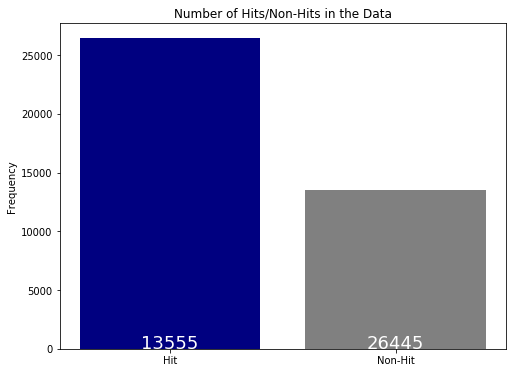

In [11]:
# Visualize the difference between the averages of the control and the mean

plt.figure(figsize=(8,6))
X = ['Hit', 'Non-Hit']
y = df['hit'].value_counts()
plt.bar(X,y, color=('navy','grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Frequency')
plt.title('Number of Hits/Non-Hits in the Data')

# STEP 2a. Questions

Of all the players in the dataset:

- Who has the most hits?
- Who hit the ball the hardest?
- What is the distribution of hits?

In [12]:
# Function to visualize and compare two distributions

def visualization(hits, non_hits):
    plt.figure(figsize=[10,6])
    sns.distplot(hits, color='blue', label='Hits', bins = 50)
    plt.axvline(hits.mean(), color='darkblue', label='Hits Mean')
    sns.distplot(non_hits, color='green', label='Non_hits', bins = 50)
    plt.axvline(non_hits.mean(), color='darkgreen', label='Non_hits Mean')
    plt.legend()
    plt.title('Hits vs. Non_hits Launch Angle')
    plt.xlabel('Distribution')
    plt.ylabel('Frequency')
    plt.show()

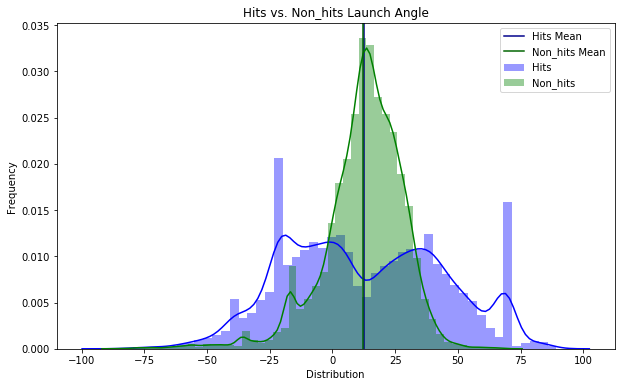

In [13]:
visualization(df.loc[df['hit']==1]['launch_angle'], df.loc[df['hit']==0]['launch_angle'])

In [15]:
#df_final = df[['game_date', 'batter', 'pitcher', 'stand',
#       'p_throws', 'home_team', 'away_team', 'launch_speed', 'launch_angle',
#       'estimated_ba_using_speedangle', 'hit']]

In [16]:
#df_final.loc[df_final['hit']==1].sort_values(by='estimated_ba_using_speedangle', ascending=False)

In [14]:
# Subsetting target variable
target = df['hit']

# Preparing features
features = df.drop(['hit'], axis = 1, inplace = False)
# Dummy variables
#features = pd.get_dummies(features)

In [15]:
df.isna().sum()

pitch_type                61
game_date                  0
release_speed            184
release_pos_x            186
release_pos_z            186
                        ... 
post_bat_score             0
post_fld_score             0
if_fielding_alignment     81
of_fielding_alignment     81
hit                        0
Length: 90, dtype: int64

In [18]:
features.shape

(40000, 89)

In [111]:
#df.isnull().sum().to_frame('nulls').sort_values(by='nulls', ascending = False).head(15)

In [17]:
#df = df.drop(['spin_rate_deprecated', 'spin_dir', 'umpire', 'tfs_zulu_deprecated', 'tfs_deprecated'], 1)
#df = df.drop('break_length_deprecated', 1)
#df['on_3b'] = df['on_3b'].fillna(0)
#df['on_2b'] = df['on_2b'].fillna(0)
#df['on_1b'] = df['on_1b'].fillna(0)
df = df.dropna()

In [150]:
# Testing/Trainging data split for model 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

In [135]:
df_final

,game_date,batter,pitcher,stand,p_throws,home_team,away_team,launch_speed,launch_angle,estimated_ba_using_speedangle,hit
0,2019-09-29,602074,607188,R,R,COL,MIL,40.0,-36.0,0.138,0
1,2019-09-29,621438,543766,R,R,COL,MIL,77.8,-37.3,0.048,1
2,2019-09-29,592325,543766,L,R,COL,MIL,80.6,35.5,0.030,1
3,2019-09-29,641658,519076,R,R,COL,MIL,106.6,14.2,0.680,1
4,2019-09-29,460077,519076,R,R,COL,MIL,86.9,44.3,0.005,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,2019-08-02,605480,501925,L,R,HOU,SEA,71.9,47.7,0.188,1
39996,2019-08-02,641477,453284,R,R,PHI,CWS,61.2,64.9,0.002,1
39997,2019-08-02,542979,501925,R,R,HOU,SEA,104.8,0.1,0.468,1
39998,2019-08-02,488726,665093,L,R,HOU,SEA,97.4,-1.4,0.395,1


In [140]:
### Model
dt = DecisionTreeClassifier(random_state=10)  

# train
dt = dt.fit(X_train, y_train)

# predict
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

# evaluate
dt_train_accuracy = accuracy_score(y_train, dt_train_preds)
dt_test_accuracy = accuracy_score(y_test, dt_test_preds)
dt_test_precision = precision_score(y_test, dt_test_preds)
dt_test_F1 = f1_score(y_test, dt_test_preds)
dt_report = classification_report(y_test, dt_test_preds)

# append accuracy score to our dataframe
score_dt = ['Vanilla Decision Tree', dt_train_accuracy, dt_test_accuracy, dt_test_precision, dt_test_F1]


['Vanilla Decision Tree', 1.0, 0.7393, 0.8124620060790274, 0.803970223325062]

In [152]:
### Model 1 - Decision Tree
dt = DecisionTreeClassifier(random_state=10)  

# train
dt = dt.fit(X_train, y_train)

# predict
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

# evaluate
dt_train_accuracy = accuracy_score(y_train, dt_train_preds)
dt_test_accuracy = accuracy_score(y_test, dt_test_preds)

# -------------------------------------------------------------

### Model 2 - Random Forest
rfc = RandomForestClassifier()

# train
rfc = rfc.fit(X_train, y_train)

# predict
rfc_train_preds = rfc.predict(X_train)
rfc_test_preds = rfc.predict(X_test)

# evaluate
rfc_train_accuracy = accuracy_score(y_train, rfc_train_preds)
rfc_test_accuracy = accuracy_score(y_test, rfc_test_preds)

# -------------------------------------------------------------

### Model 3 - Adaboost
adaboost = AdaBoostClassifier()

# train
adaboost = adaboost.fit(X_train, y_train)

# predict
adaboost_train_preds = adaboost.predict(X_train)
adaboost_test_preds = adaboost.predict(X_test)

# evaluate
adaboost_train_accuracy = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_accuracy = accuracy_score(y_test, adaboost_test_preds)

# -------------------------------------------------------------
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")
print('\n')
print('------------------------------------------------------')
print('\n')
print('Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_test_accuracy * 100):.4}%")
print('\n')
print('------------------------------------------------------')
print('\n')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")


Vanilla Decision Tree
------------------------------------------------------
Training Accuracy: 100.0%
Test Accuracy:     73.9%


------------------------------------------------------


Random Forest
------------------------------------------------------
Training Accuracy: 99.02%
Test Accuracy:     79.11%


------------------------------------------------------


Adaboost
------------------------------------------------------
Training Accuracy: 80.13%
Test Accuracy:     80.24%


In [ ]:
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")

In [146]:
results = pd.DataFrame(results)

In [147]:
results

,Model,Training Accuracy,Testing Accuracy
0,Decision Tree,80.173333,80.36
1,Random Forest,98.800000,79.21
2,Adaboost,80.346667,80.55


In [148]:
print('Classification Report Vanilla Decision Tree: \n', dt_report)
print('------------------------------------------------------')
print('')
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")

Classification Report Vanilla Decision Tree: 
               precision    recall  f1-score   support

           0       0.60      0.62      0.61      3281
           1       0.81      0.80      0.80      6719

    accuracy                           0.74     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.74      0.74      0.74     10000

------------------------------------------------------

Vanilla Decision Tree
------------------------------------------------------
Training Accuracy: 80.17%
Test Accuracy:     80.36%


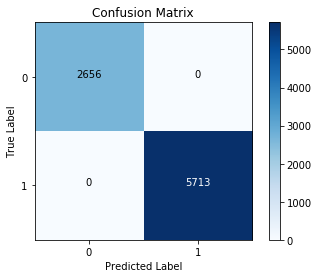

In [119]:
show_cf(y_test, dt_test_preds)

In [123]:
feat_importance = dt.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0. 0. 0. ... 0. 0. 0.]


In [25]:
# model
rfc = RandomForestClassifier()

# train
rfc = rfc.fit(X_train, y_train)

# predict
rfc_train_preds = rfc.predict(X_train)
rfc_test_preds = rfc.predict(X_test)

# evaluate
rfc_train_accuracy = accuracy_score(y_train, rfc_train_preds)
rfc_test_accuracy = accuracy_score(y_test, rfc_test_preds)
rfc_test_precision = precision_score(y_test, rfc_test_preds)
rfc_test_F1 = f1_score(y_test, rfc_test_preds)
rfc_report = classification_report(y_test, rfc_test_preds)

# append accuracy score to our dataframe
score_rfc = ['Random Forest', rfc_train_accuracy, rfc_test_accuracy, rfc_test_precision, rfc_test_F1]

/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:

print('Classification Report Random Forest: \n', rfc_report)
print('------------------------------------------------------')
print('')
print('Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_test_accuracy * 100):.4}%")

Classification Report Random Forest: 
               precision    recall  f1-score   support

           0       0.69      0.68      0.69      3407
           1       0.84      0.84      0.84      6593

    accuracy                           0.79     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.79      0.79      0.79     10000

------------------------------------------------------

Random Forest
------------------------------------------------------
Training Accuracy: 99.04%
Test Accuracy:     78.61%


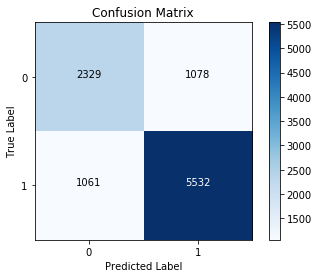

In [27]:
show_cf(y_test, rfc_test_preds)

In [28]:
import warnings
warnings.filterwarnings("ignore")
# model
adaboost = AdaBoostClassifier()

# train
adaboost = adaboost.fit(X_train, y_train)

# predict
adaboost_train_preds = adaboost.predict(X_train)
adaboost_test_preds = adaboost.predict(X_test)

# evaluate
adaboost_train_accuracy = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_accuracy = accuracy_score(y_test, adaboost_test_preds)
adaboost_test_precision = precision_score(y_test, adaboost_test_preds)
adaboost_test_F1 = f1_score(y_test, adaboost_test_preds)
adaboost_report = classification_report(y_test, adaboost_test_preds)

# append accuracy score to our dataframe
score_adaboost = ['Adaboost', adaboost_train_accuracy, adaboost_test_accuracy, adaboost_test_precision, adaboost_test_F1]

In [29]:
print('Classification Report Adaboost: \n', adaboost_report)
print('------------------------------------------------------')
print('')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")

Classification Report Adaboost: 
               precision    recall  f1-score   support

           0       0.72      0.69      0.70      3407
           1       0.84      0.86      0.85      6593

    accuracy                           0.80     10000
   macro avg       0.78      0.77      0.78     10000
weighted avg       0.80      0.80      0.80     10000

------------------------------------------------------

Adaboost
------------------------------------------------------
Training Accuracy: 80.4%
Test Accuracy:     80.01%


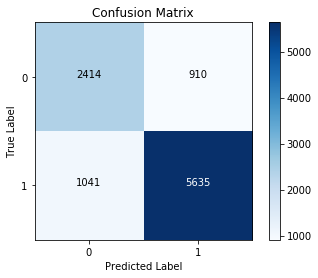

In [40]:
show_cf(y_test, adaboost_test_preds)